In [15]:
# !pip install qiskit
# !pip install qiskit_ibm_runtime
# !pip install matplotlib
# !pip install pylatexenc
# !pip install qiskit_aer

In [16]:
import math
from math import pi, asin, sqrt, floor
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session as Session
# from qiskit.primitives import StatevectorSampler as Sampler

# service = QiskitRuntimeService(channel="ibm_quantum",token="dd63143b2482be4578a9c8a3b57387eb937513750a212cc004f0cc09303cbf32f4a3702df59fee1b37d1f5338d6f15db61cf554c3d4f96d44cfb9845ff5560f0")
# backend = service.least_busy(operational=True, simulator=False)

# backend.name

In [17]:
def grover_oracle(marked_states): # implementing Zf Phase query gate
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0]) #if there are 3 bits so qc with 3 qubits and so on

    qc = QuantumCircuit(num_qubits)



    for target in marked_states:
        rev_target = target[::-1] # rev as qiskit uses little endiane

        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)] # finding starting qubit 0


        qc.x(zero_inds)

        qc.barrier(range(num_qubits))
        #Multi control CCZ gate
        qc.h(num_qubits - 1)
        qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        qc.h(num_qubits - 1)

        qc.barrier(range(num_qubits))

        qc.x(zero_inds)
    return qc

In [18]:
def diffusion_operator(num_qubits): # implementing HZorH gate or diffusion

    qc = QuantumCircuit(num_qubits)


    qc.h(range(num_qubits))    # H


    qc.x(range(num_qubits))    # X

    qc.barrier(range(num_qubits))

    # multicontrolled ccZ gate
    qc.h(num_qubits - 1)
    qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    qc.h(num_qubits - 1)

    qc.barrier(range(num_qubits))


    qc.x(range(num_qubits))    #  X gates reverting to og


    qc.h(range(num_qubits))    # H

    return qc

In [19]:
def encode(input_strings):
  binary_strings = []
  for input_string in input_strings:
    # print(input_string.encode('utf-8'))
    binary_string = ''.join(format(ord(char), '08b') for char in input_string)
    binary_strings.append(binary_string)
  return binary_strings



input_strings = input("Enter a list of strings separated by spaces: ").split()


marked_states = encode(input_strings)
# marked_states = ['0101001','0011101']
print(marked_states)

['011000110110000101110100', '011001000110111101100111', '011100110110101101111001']


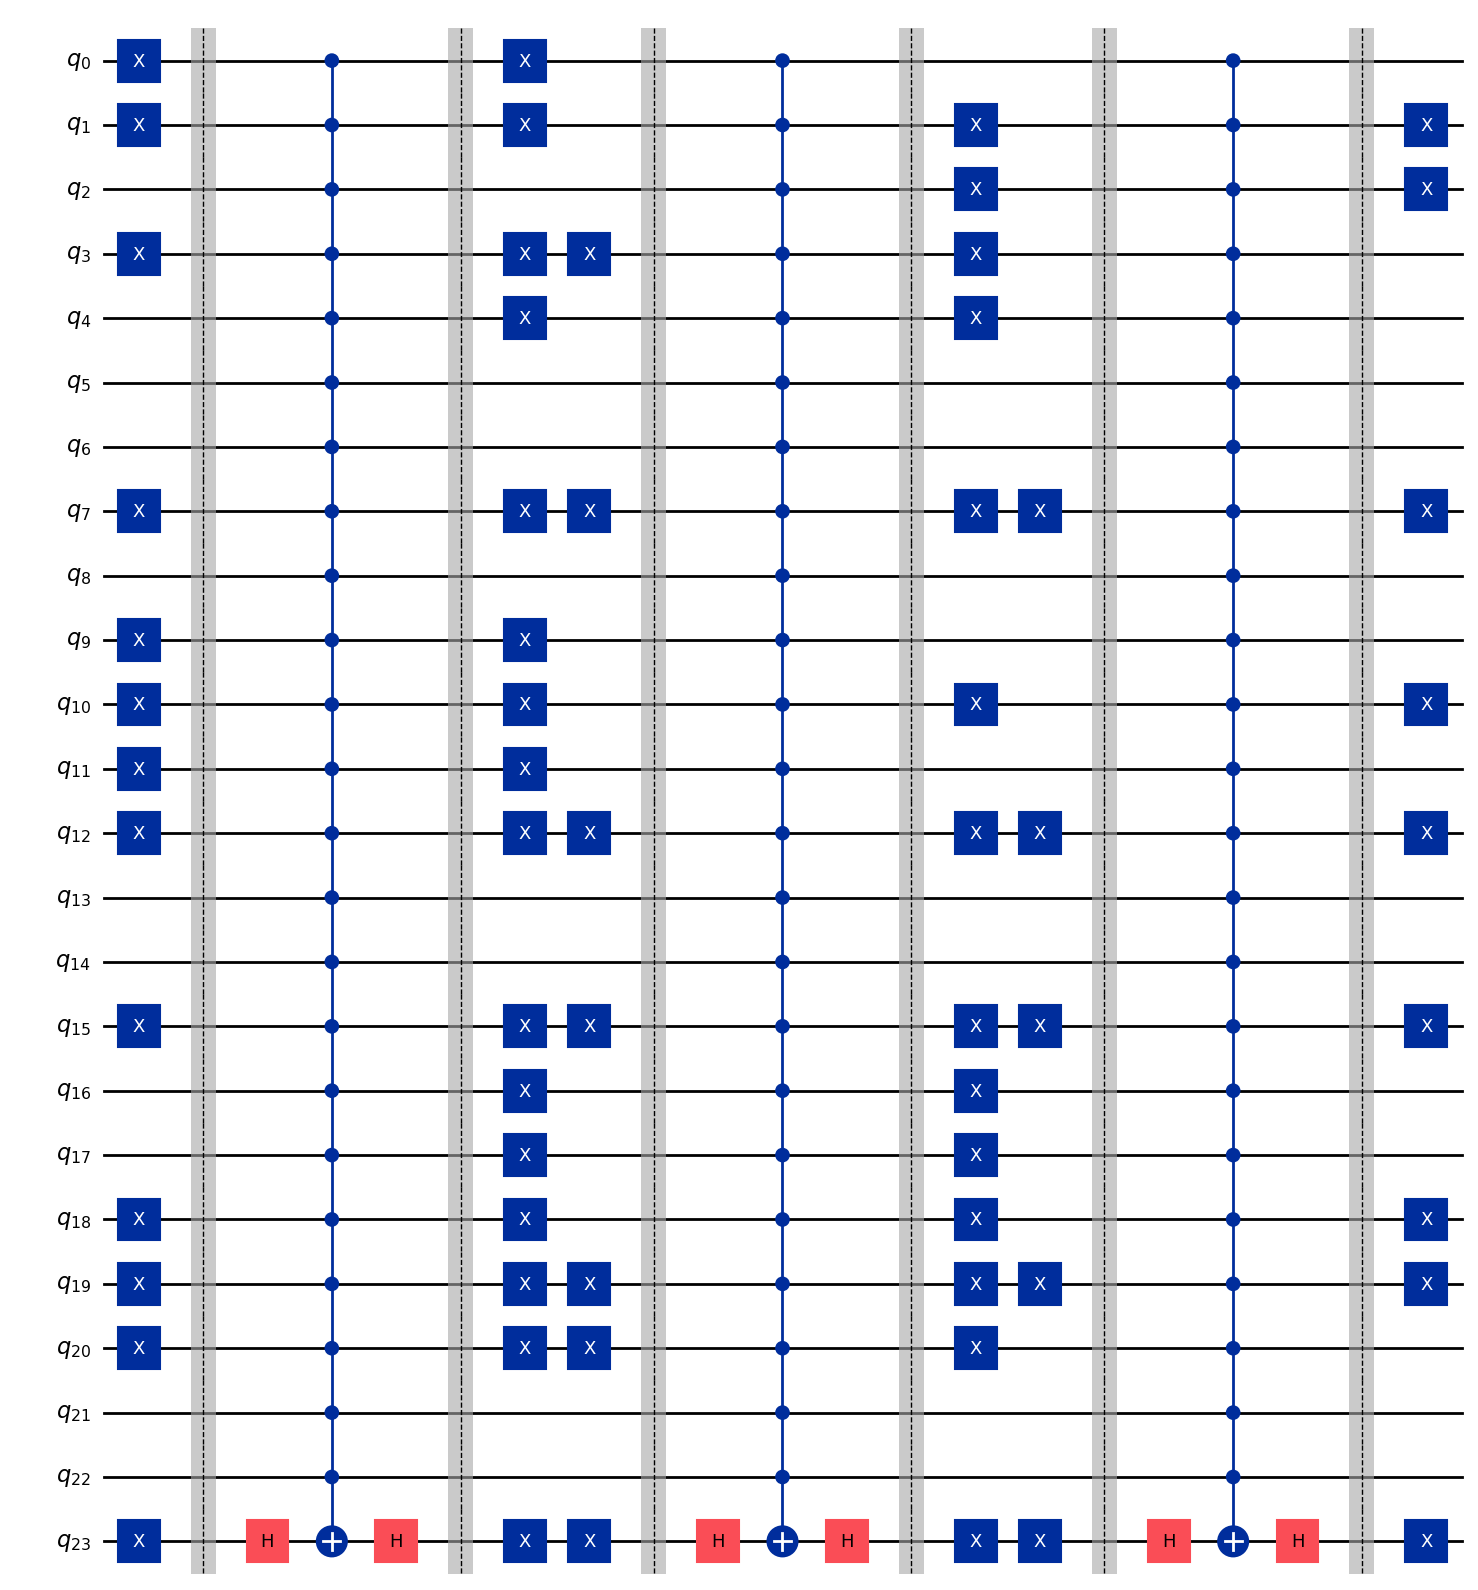

In [20]:
num_qubits = len(marked_states[0]) #if there are 3 bits so qc with 3 qubits and so on


oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

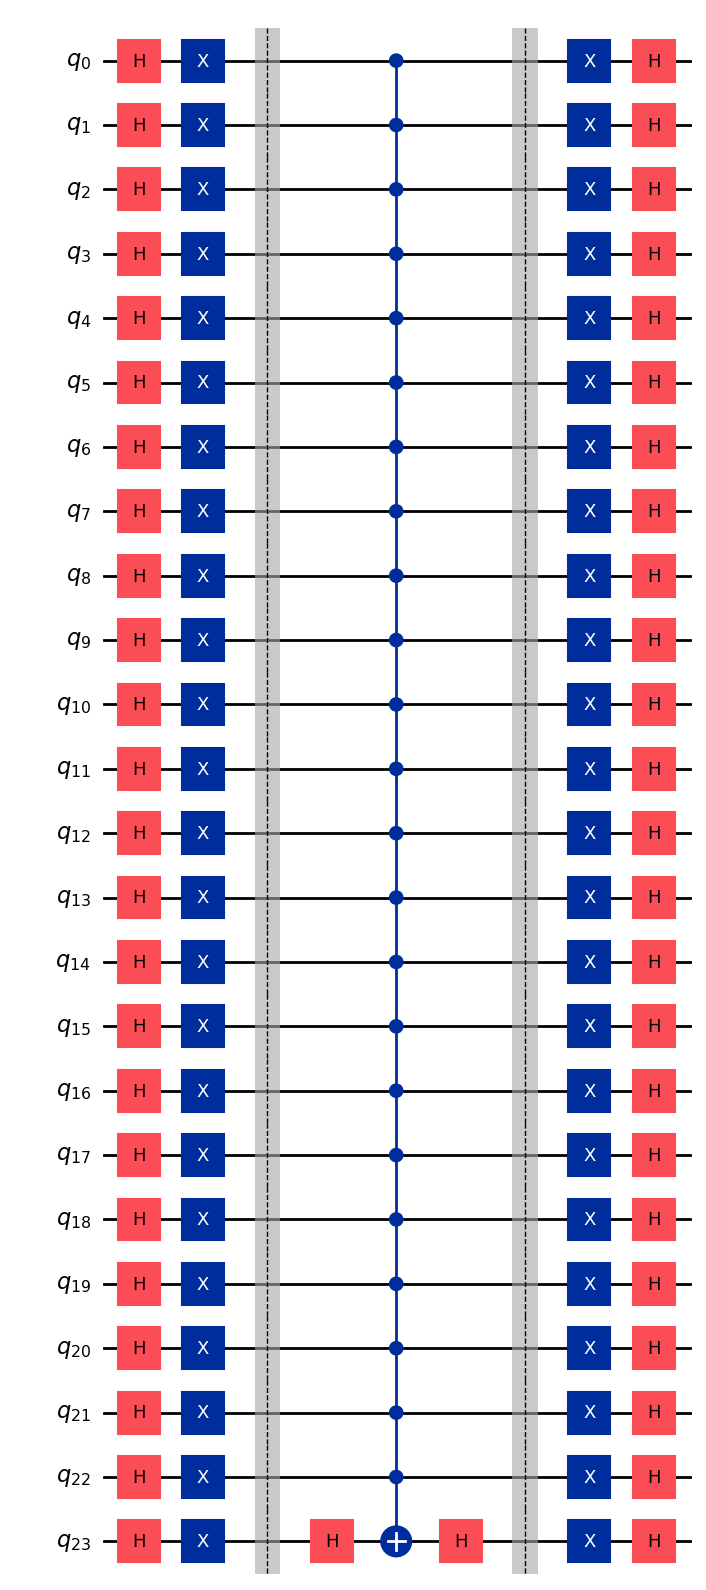

In [21]:
diffusion = diffusion_operator(num_qubits)
diffusion.draw(output="mpl", style="iqp")


In [22]:
qc = QuantumCircuit(num_qubits)

# uniform superposition
qc.h(range(num_qubits))

num_iterations = floor(pi / (4 * asin(sqrt(len(marked_states) / 2**num_qubits))))

for _ in range(num_iterations): # running grover for the stipulated time
    qc.compose(oracle, inplace=True)
    qc.compose(diffusion, inplace=True)

qc.measure_all()
# qc.draw(output="mpl", style="iqp")

In [23]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=1)

# circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [24]:
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 1024
# result = sampler.run([circuit_isa]).result()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session as Session

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_circuit = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

{'01100011': 342, '00110001': 339, '01100001': 339, '00010111': 1, '00010010': 1, '01110110': 1, '00010000': 1}


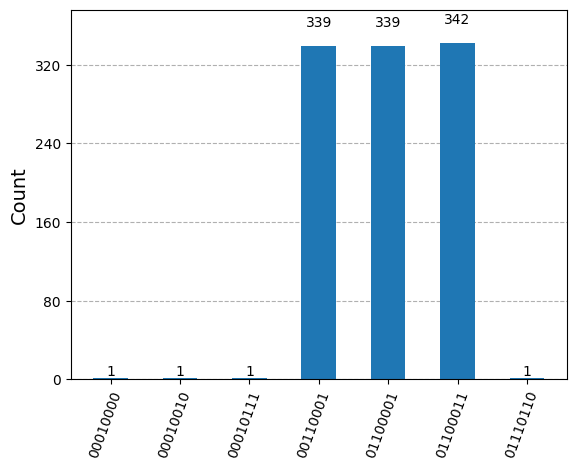

In [11]:
from qiskit.visualization import plot_histogram

outputs = result[0].data.meas
counts = outputs.get_counts()
# print(len(outputs.array))
print(counts)
display(plot_histogram(counts))

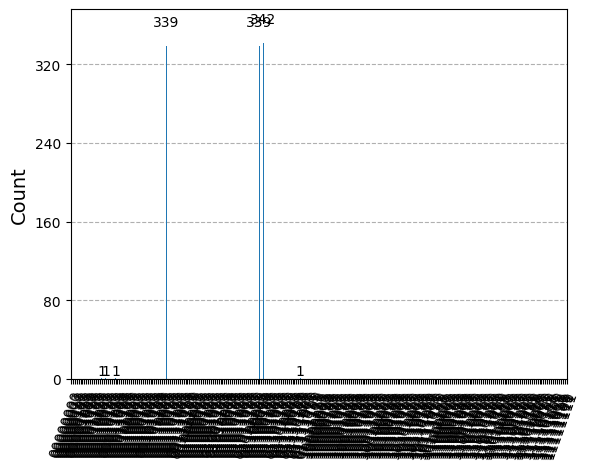

In [12]:
all_possible_states = [bin(x)[2:].zfill(num_qubits) for x in range(2**num_qubits)]
for state in all_possible_states:
    if state not in counts:
        counts[state] = 0

# display(plot_histogram(counts))

In [ ]:
import numpy as np

check = input("Enter a list of strings separated by spaces to check: ").split()
print(check)
check_bin = encode(check)
print(check_bin)

def decode(binary_strings):
  decoded_strings = []
  for binary_string in binary_strings:
    decoded_string = ""
    for i in range(0, len(binary_string), 8):
      byte = binary_string[i:i + 8]
      decoded_string += chr(int(byte, 2))
    decoded_strings.append(decoded_string)
  return decoded_strings

mean_prob = np.mean(list(counts.values()))
# stdev = np.std(list(counts.values()))
# print(mean_prob, stdev)
for bin_str in check_bin:
  # probability = get_state_probability(counts, bin_str)
  if (bin_str in counts) and  (counts[bin_str] >= mean_prob):
    print(decode([bin_str]), "is present in the list")
  else:
    print(decode([bin_str]), "is not present in the list")

['1', 'a', 'd']
['00110001', '01100001', '01100100']
['1'] is present in the list
['a'] is present in the list
['d'] is not present in the list
